In [ ]:
#@title

from IPython.display import Math, HTML
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))
import matplotlib.pyplot as plt


import numpy as np
import scipy
import scipy.integrate
import scipy.interpolate


def conditionedMinimum(t, xt, sigma, minimum):
    '''PDF of GBM minimum, given a known ending value Xt
    '''
    j = t*sigma**2    
    return np.where(
        np.logical_or(xt < 0.0, minimum >= xt),
        0,
        -2*np.log(minimum**2 /xt) * np.exp(
            (np.log(xt)**2 - np.log(minimum**2 / xt)**2) / (2*j)
        ) / (minimum * j)
    )

def gbmEval(mu, sigma, t, zscore):
    '''Useful function
    '''
    return np.exp(
        t*(mu-(1/2)*sigma**2) + (sigma * t**0.5) * zscore
    )

def gbmPDF(t, mu, sigma, xt):
    '''Density function of GBM with given parameters
    '''
    return (2*np.pi * (sigma * xt)**2)**(-1/2) * np.exp(
        -(np.log(xt) - t*(mu-sigma**2 / 2))**2 / (2*t*sigma**2)
    )



class GBMMinimum:
    def __init__(
        self, t, mu, sigma,
        n_min_samples=1_000, n_xt_samples=1_000, maxz=4
    ):
        self.mu = mu
        self.t = t
        self.sigma = sigma
        
        gbmSampleMin, gbmSampleMax = tuple(
            gbmEval(mu, sigma, t, np.asarray([-maxz, maxz]))
        )

        xt = np.geomspace(
            gbmSampleMin, gbmSampleMax, n_xt_samples
        )
        self._pt = np.linspace(0, 1, n_min_samples+1, endpoint=True)[1:]
        mins, mxt = np.meshgrid(
            self._pt,
            xt
        )

        self._pdf_eval = gbmPDF(t,mu,sigma,xt).reshape(-1,1) * conditionedMinimum(t, mxt, sigma, mins)

        self._pdf = scipy.integrate.simps(self._pdf_eval, xt, axis=0)
        
        self._cdf = scipy.integrate.cumtrapz(self._pdf, self._pt, initial=0)

        self._pdf_interp = scipy.interpolate.interp1d(
            x = self._pt,
            y = self._pdf,
            bounds_error=False,
            fill_value=(0,0),
            copy=False,
            assume_sorted=True
        )
        self._cdf_interp = scipy.interpolate.interp1d(
            x = self._pt,
            y = self._cdf,
            bounds_error=False,
            fill_value=(0,1),
            copy=False,
            assume_sorted=True
        )
        self._inverse_cdf_interp = scipy.interpolate.interp1d(
            x = self._cdf,
            y = self._pt,
            bounds_error=False,
            fill_value=(0,1),
            copy=False,
            assume_sorted=True,
        )


    def pdf(self, xs):
        '''Density function of distribution at certain points
        '''
        return self._pdf_interp(xs)
        
    def cdf(self, xs):
        '''CDF of distribution at certain points
        '''
        return self._cdf_interp(xs)
    
    def inverse_cdf(self, ps):
        '''At a given confidence level,
        What minimum can we expect the function not to exceed over the time?

        Or, for just inverse of CDF
        '''
        return self._inverse_cdf_interp(ps)

In [ ]:
#@title
print('''
The density function of a Geometric Brownian random variable
(assuming S_0 = 1) is given by:
''')
Math(
r'''
    P(S_t)
    = \frac{1}{\sqrt{2 \pi t}} \frac{1}{s\sigma}
    \exp \Bigg( - \frac{\left( \log S_t -
    t \left( \mu - \frac{1}{2} \sigma ^2 \right) \right)^{2}} {2 t \sigma^{2}}
    \Bigg)
'''
)


The density function of a Geometric Brownian random variable
(assuming S_0 = 1) is given by:



<IPython.core.display.Math object>

In [ ]:
#@title
print('''
McLeish (2002) established that the minimum can be simulated,
conditioned on S_t
''')
Math(
r'''
    P(\min_{\left[0,t\right]}(S_t) = x | S_t) ^ -1
    = \sqrt{
        S_t \exp { \bigg( - \sqrt{ -2 \sigma^2 t x - \log \left( S_t \right) ^2 }\bigg)}
    }
'''
)


McLeish (2002) established that the minimum can be simulated,
conditioned on S_t



<IPython.core.display.Math object>

In [ ]:
#@title
print('''
Moreover, this can be manipulated into an
explicit density function conditioned on the end value:
''')


Math(
r'''
    P(\min_{\left[0,t\right]}(S_t) = x | S_t)
    = \begin{array}{cc}
        \Bigg \{ & 
            \begin{array}{cc}
            0 & x \geq \min (1, S_0) \\
            -\frac{
                2 \log{\frac{x^2}{S_t}}
                \exp \bigg( \frac{\log{(S_t)}^2 - \log{\frac{x^2}{S_t}}} {2 t \sigma ^2} \bigg)
            } {x * t * \sigma ^2} & x \lt \min (1, S_0)
            \end{array}
        \end{array}
'''
)


Moreover, this can be manipulated into an
explicit density function conditioned on the end value:



<IPython.core.display.Math object>

In [ ]:
#@title
print('''
Together, we can find an explicit formula for the density function of
the minimum of GBM over some interval:
''')


Math(
r'''
    P(\min_{\left[0,t\right]}(S_t) = x ) =
    P(\min_{\left[0,t\right]}(S_t) = x | S_t ) * P(S_t = x)
'''
)


Together, we can find an explicit formula for the density function of
the minimum of GBM over some interval:



<IPython.core.display.Math object>

Since to find the relevent integrals needed for a CDF and an inverse CDF are expensive to compute on-demand, we can sample them ahead-of-time over their support and interpolate quickly on-demand.

In [ ]:
#@title
# Initial value, X_0
X0 = 4070

# Timespan for process
t = 1/12.0

# Brownian drift of distribution, per unit time
mu = 0.07

# Dispersion, or volatility
sigma = 0.20

# Percent chance of ruin (think VAR)
alphas = np.asarray([0.05, 0.25, 0.5, 0.75, 0.95])


# You shouldn't really have to touch this
figsize = (12,6)

In [ ]:
#@title
# How many contracts can we buy before risk of being closed out over interval
# is higher than alpha?

def contracts_at_level(cash, S_0, S_m, maintinance_margin, mult=1.0):
    '''How many futures contracts would we need
    to to exactly blow up at the specified futures price, S_m?

    Given we have cash, futures is at S_0 now, and for some margin level
    '''
    # print(S_0-S_m)

    # return (cash - mult * (S_0 - S_m)) / maintinance_margin
    return cash / (maintinance_margin - mult*(S_m-S_0))


5.0% chance of reaching 3,773.82
25.0% chance of reaching 4,033.50
50.0% chance of reaching 4,070.00
75.0% chance of reaching 4,070.00
95.0% chance of reaching 4,070.00


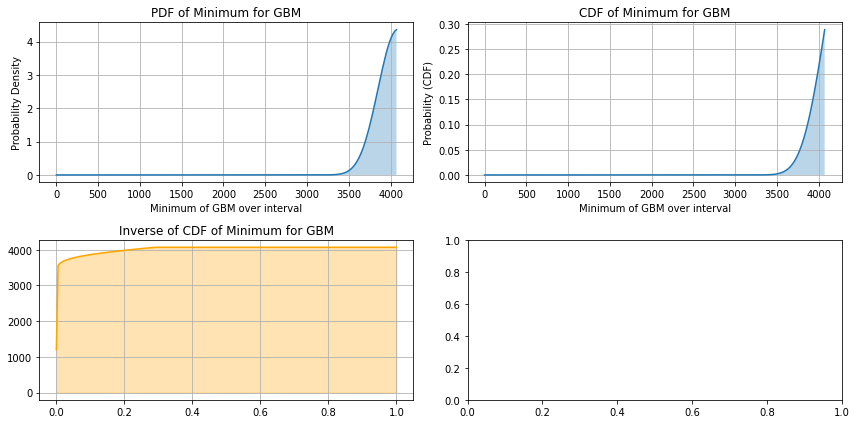

In [ ]:
#@title

# Instantiate our GBM process
gbm_m = GBMMinimum(
    t = t,
    mu = mu,
    sigma = sigma,
)
icdfa = X0 * gbm_m.inverse_cdf(alphas)
for a, x in zip(alphas,icdfa):
    print("{0:.1f}% chance of reaching {1:,.2f}".format(
        a*100.0,
        x
    ))

#################
# Plots are all below
xs = np.linspace(0, 1, 200)
px = xs * X0
fig, axs = plt.subplots(2,2, figsize=figsize)

# PDF Plot
ax = axs.flatten()
ax[0].plot(
    px,
    gbm_m.pdf(xs),
    label='pdf'
)
ax[0].fill_between(px,gbm_m.pdf(xs), alpha=0.3)
ax[0].set_title('PDF of Minimum for GBM')
ax[0].set_xlabel('Minimum of GBM over interval')
ax[0].set_ylabel('Probability Density')
ax[0].grid()


# CDF Plot
ax[1].plot(
    px,
    gbm_m.cdf(xs),
    label='cdf'
)
ax[1].fill_between(px,gbm_m.cdf(xs), alpha=0.3)
ax[1].set_title('CDF of Minimum for GBM')
ax[1].set_xlabel('Minimum of GBM over interval')
ax[1].set_ylabel('Probability (CDF)')
# ax[1].legend()
ax[1].grid()


# Inverse CDF Plot
ax[2].plot(
    xs,
    X0*gbm_m.inverse_cdf(xs),
    label='inverse_cdf',
    c='orange'
)
ax[2].fill_between(xs,X0*gbm_m.inverse_cdf(xs), alpha=0.3, color='orange')
ax[2].set_title('Inverse of CDF of Minimum for GBM')
ax[2].grid()


plt.tight_layout()
plt.show()

In [ ]:
# Chance of margin call
alpha = 0.10

# Maintinance margin
m_margin = 1200

# Multiplier, taking index to dollars
mult = 5.0

cash = 40_000


########################################
# Shouldn't have to mess around down here

# At what level can we expect to find minimum over timeperiod?
icdfa = X0 * gbm_m.inverse_cdf(alpha)

# How many contracts we can own
num_contracts = np.floor(contracts_at_level(
    cash = cash,
    S_0 = X0,
    S_m = icdfa,
    maintinance_margin = m_margin,
    mult=mult
))

In [ ]:
#@title
print(
    'We expect asset to find support at {0:,.2f} at the {1:.0f}% confidence level'.format(
        icdfa,
        100*alpha
    )
)
print(
    'We can own {0:,.0f} contracts, with VAR of ${1:,.0f} at the {2:.0f}% confidence level'.format(
        num_contracts,
        cash,
        100*alpha
    )
)
exposure = mult*X0*num_contracts

leverage = exposure / cash

'Total exposure: ${0:,.2f} ({1:.1f}x levered)'.format(exposure, leverage)

We expect asset to find support at 3,864.70 at the 10% confidence level
We can own 17 contracts, with VAR of $40,000 at the 10% confidence level


'Total exposure: $345,950.00 (8.6x levered)'